In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report,confusion_matrix
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [2]:
#DATASET_PATH  = './catsdogs/sample'
#IMAGE_SIZE    = (299, 299)
#NUM_CLASSES   = 2
#BATCH_SIZE    = 8  # try reducing batch size or freeze more layers if your GPU runs out of memory
FREEZE_LAYERS = 2  # freeze the first this many layers for training
#NUM_EPOCHS    = 20
#WEIGHTS_FINAL = 'model-inception_resnet_v2-final.h5'


img_width, img_height = 128,128 # make it bigger

train_data_dir = 'C:/Users/tevin/Collaborations\Habib - Haar - Tevin/Data/Cropped images/Draft1/Train'
test_data_dir = 'C:/Users/tevin/Collaborations\Habib - Haar - Tevin/Data/Cropped images/Draft1/Test'

#Go on a 8:20 spil
#267:67
nb_train_samples = 160
nb_test_samples = 40
epochs = 40
batch_size = 4



#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                   rotation_range=40,
#                                   width_shift_range=0.2,
#                                   height_shift_range=0.2,
#                                   shear_range=0.2,
#                                   zoom_range=0.2, must be there
#                                   channel_shift_range=10,
#                                   horizontal_flip=True, must be there
#                                   fill_mode='nearest')

#CONSIDER REMOVING PREPROCESS INPUT AND ADDING RESCALE BACK IN relook at hthe data augmentation
train_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1. / 255,
        #horizontal_flip=True,
        shear_range=0.2, # remoce 
        zoom_range=0.2) 

    # this is the augmentation configuration we will use for testing:
    # only rescaling
test_datagen = ImageDataGenerator(
        #preprocessing_function=preprocess_input,
        rescale=1. / 255,
        #horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        #interpolation='bicubic',
        #shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        #interpolation='bicubic',
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')



Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [3]:


model = InceptionResNetV2(include_top=False, #try and enable
                        weights=None,#'imagenet', 
                        input_tensor=None,
                        input_shape=(img_width, img_height, 3))

#Ask if i am to add the glabal average pooling                          
x = model.output # remove all this
#add the average global layer 
#x = Flatten()(x)
#x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
#do the global and then follow by a dense layer for binary classification x = Dense(1, activation='softmax')(x)

#x = Dense(2, activation='softmax')(x)
output_layer = Dense(2, activation='softmax', name='softmax')(x)
net_final = Model(inputs=model.input, outputs=output_layer)
#for layer in net_final.layers[:FREEZE_LAYERS]:
#    layer.trainable = False
#for layer in net_final.layers[FREEZE_LAYERS:]:
#    layer.trainable = True

net_final.summary()

# (4) Compile 
net_final.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

filepath="C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.Inception2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
    
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

history = net_final.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=test_generator,
    validation_steps=nb_test_samples // batch_size,
    epochs=epochs,
    callbacks=[checkpoint,early])



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 63, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 63, 63, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

activation_179 (Activation)     (None, 2, 2, 192)    0           batch_normalization_179[0][0]    
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 2, 2, 256)    0           batch_normalization_182[0][0]    
__________________________________________________________________________________________________
block8_5_mixed (Concatenate)    (None, 2, 2, 448)    0           activation_179[0][0]             
                                                                 activation_182[0][0]             
__________________________________________________________________________________________________
block8_5_conv (Conv2D)          (None, 2, 2, 2080)   933920      block8_5_mixed[0][0]             
__________________________________________________________________________________________________
block8_5 (Lambda)               (None, 2, 2, 2080)   0           block8_4_ac[0][0]                
          

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 1.5023 - accuracy: 0.5500
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training\weights.Inception2.hdf5
40/40 [==============================] - 37s 927ms/step - loss: 1.5023 - accuracy: 0.5500 - val_loss: 0.6977 - val_accuracy: 0.5000
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.6313
Epoch 00002: val_accuracy did not improve from 0.50000
40/40 [==============================] - 32s 791ms/step - loss: 0.6953 - accuracy: 0.6313 - val_loss: 0.9471 - val_accuracy: 0.5000
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.6438
Epoch 00003: val_accuracy did not improve from 0.50000
40/40 [==============================] - 32s 793ms/step - loss: 0.7328 - accuracy: 0.6438 - val_loss: 2.1601 - val_accuracy: 0.5000
Epoch 4/40
40/40 [==============================] - ETA

40/40 [==============================] - ETA: 0s - loss: 0.3996 - accuracy: 0.8750
Epoch 00028: val_accuracy did not improve from 0.97500
40/40 [==============================] - 34s 845ms/step - loss: 0.3996 - accuracy: 0.8750 - val_loss: 5.4064 - val_accuracy: 0.5500
Epoch 29/40
40/40 [==============================] - ETA: 0s - loss: 0.3956 - accuracy: 0.8750
Epoch 00029: val_accuracy did not improve from 0.97500
40/40 [==============================] - 33s 816ms/step - loss: 0.3956 - accuracy: 0.8750 - val_loss: 1.7223 - val_accuracy: 0.7750
Epoch 30/40
40/40 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8875
Epoch 00030: val_accuracy did not improve from 0.97500
40/40 [==============================] - 34s 839ms/step - loss: 0.3475 - accuracy: 0.8875 - val_loss: 0.1490 - val_accuracy: 0.9000
Epoch 31/40
40/40 [==============================] - ETA: 0s - loss: 0.2396 - accuracy: 0.9187
Epoch 00031: val_accuracy did not improve from 0.97500
40/40 [=========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.550000011920929, 0.6312500238418579, 0.643750011920929, 0.7250000238418579, 0.7749999761581421, 0.7875000238418579, 0.7875000238418579, 0.78125, 0.8812500238418579, 0.8999999761581421, 0.8687499761581421, 0.90625, 0.887499988079071, 0.949999988079071, 0.9125000238418579, 0.9312499761581421, 0.90625, 0.9750000238418579, 0.8812500238418579, 0.9312499761581421, 0.737500011920929, 0.875, 0.831250011920929, 0.65625, 0.762499988079071, 0.731249988079071, 0.824999988079071, 0.875, 0.875, 0.887499988079071, 0.918749988079071, 0.9125000238418579, 0.9375, 0.918749988079071, 0.96875, 0.831250011920929]


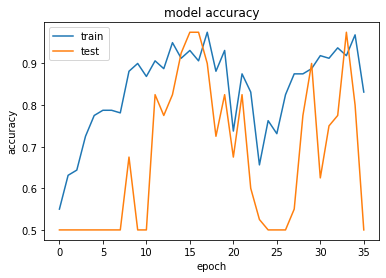

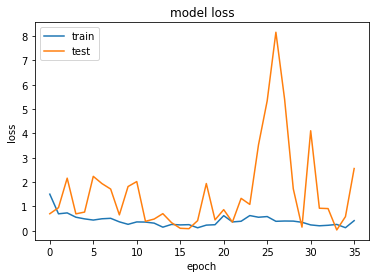

In [4]:
# list all data in history
#plt.figure(figsize=(15,8))

print(history.history.keys())
print(history.history['accuracy'])

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/InceptionV2Resnet/AccuracyCurve2.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/InceptionV2Resnet/LossCurve2.png')
plt.show()

#loss, acc = model.evaluate_generator(test_generator, nb_test_samples // batch_size+1)
#print(acc * 100)
#print(loss * 100)

#take off shuiffle

In [5]:
from tensorflow import keras
from keras.models import load_model


model2 = keras.models.load_model('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.Inception2.hdf5')

#model.load_weights("C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Training/weights.Inception.hdf5")
# Compile model (required to make predictions)
model2.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print("Created model and loaded weights from file")


loss, accuracy = model2.evaluate_generator(test_generator, nb_test_samples // batch_size, verbose=0)
print(accuracy)
print(loss)

Created model and loaded weights from file
Instructions for updating:
Please use Model.evaluate, which supports generators.
0.925000011920929
0.11140494048595428


[[9.9281245e-01 7.1875108e-03]
 [9.6987814e-01 3.0121896e-02]
 [9.6005672e-01 3.9943285e-02]
 [9.5583582e-01 4.4164188e-02]
 [9.8799229e-01 1.2007644e-02]
 [9.9800891e-01 1.9910622e-03]
 [7.9144681e-01 2.0855317e-01]
 [9.9242073e-01 7.5792964e-03]
 [9.5886356e-01 4.1136470e-02]
 [9.6328241e-01 3.6717549e-02]
 [9.9573672e-01 4.2632823e-03]
 [8.3290321e-01 1.6709681e-01]
 [9.6030182e-01 3.9698184e-02]
 [9.9529606e-01 4.7039324e-03]
 [9.9682719e-01 3.1727988e-03]
 [9.8497653e-01 1.5023460e-02]
 [9.9241465e-01 7.5854110e-03]
 [9.9210620e-01 7.8938361e-03]
 [9.8163903e-01 1.8360933e-02]
 [9.9338293e-01 6.6171549e-03]
 [1.1321593e-01 8.8678402e-01]
 [2.7943781e-04 9.9972051e-01]
 [1.4934187e-01 8.5065818e-01]
 [4.4651488e-03 9.9553490e-01]
 [1.0421040e-03 9.9895787e-01]
 [6.4391401e-03 9.9356091e-01]
 [4.3082020e-01 5.6917977e-01]
 [3.4034747e-01 6.5965253e-01]
 [3.6840464e-04 9.9963152e-01]
 [6.6931476e-04 9.9933076e-01]
 [3.7406728e-01 6.2593269e-01]
 [7.9823732e-03 9.9201763e-01]
 [2.6019

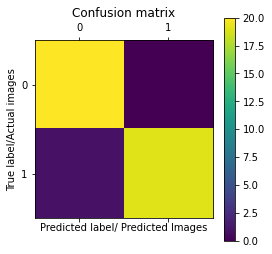

In [7]:
preds3 = model2.predict_generator(test_generator, nb_test_samples // batch_size)
#print(test_generator.classes.shape)
#print(np.shape(preds3))
print(preds3)
prediction2 = np.argmax(preds3, axis=1)

print(preds3)

print('this is the predicted data')
print(prediction2)
print('this is the test data')
print(test_generator.classes)

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, prediction2)
print(cm)


print('Classification Report')
#target_names = ['Noise','Strokes']
print(classification_report(test_generator.classes, prediction2))

plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label/Actual images')
plt.xlabel('Predicted label/ Predicted Images')
plt.savefig('C:/Users/tevin/Collaborations/Habib - Haar - Tevin/Results/InceptionV2Resnet/Confusion2.png')
plt.show()